In [1]:
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
import dags.scripts.preprocess as pr
import dags.scripts.set_matplotlib_hangul as set_matplotlib_hangul


Hangul OK in your Windows!!!


In [2]:
# Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞Îü¨Ïò§Í∏∞
def load_csv():
    orders = pd.read_csv('./dags/data/orders.csv')
    aisles = pd.read_csv('./dags/data/aisles.csv')
    departments = pd.read_csv('./dags/data/departments.csv')
    order_products_prior = pd.read_csv('./dags/data/order_products__prior.csv')
    order_products_train = pd.read_csv('./dags/data/order_products__train.csv')
    products = pd.read_csv('./dags/data/products.csv')

    return orders, aisles, departments, order_products_prior, order_products_train, products

In [3]:
# Ìï®Ïàò Ìò∏Ï∂ú
orders, aisles, departments, order_products_prior, order_products_train, products = load_csv()

In [4]:
# Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨Î¶¨
def clean_orders(orders):
    orders['days_since_prior_order'].fillna(0, inplace=True)
    return orders

In [5]:
# Ìï®Ïàò Ìò∏Ï∂ú
orders = clean_orders(orders)
orders.isnull().sum()

order_id                  0
user_id                   0
eval_set                  0
order_number              0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
dtype: int64

In [6]:
# Îç∞Ïù¥ÌÑ∞ ÌõàÎ†®Îç∞Ïù¥ÌÑ∞ÏôÄ Ï†ïÎãµÎç∞Ïù¥ÌÑ∞ Î∂ÑÎ¶¨
def split_orders(orders):
    orders_prior = orders[orders['eval_set'] == 'prior'].drop(columns=['eval_set'])
    orders_train = orders[orders['eval_set'] == 'train'].drop(columns=['eval_set'])
    return orders_prior, orders_train


In [7]:
# Ìï®Ïàò Ìò∏Ï∂ú
orders_prior, orders_train = split_orders(orders)

In [8]:
# Î∂àÌïÑÏöîÌïú Ïª¨Îüº ÏÇ≠Ï†úÏ†ú
def clean_order_products(df):
    if 'add_to_cart_order' in df.columns:
        return df.drop(columns=['add_to_cart_order'])
    return df

In [9]:
# Ìï®Ïàò Ìò∏Ï∂ú
order_products_prior = clean_order_products(order_products_prior)
order_products_train = clean_order_products(order_products_train)


In [10]:
# Îç∞Ïù¥ÌÑ∞ Ìï©ÏπòÍ∏∞
def merge_dataframes(orders_prior, order_products_prior, products, departments, aisles):
    df_total = orders_prior.merge(order_products_prior, on='order_id', how='left')
    df_total = df_total.merge(products, on='product_id', how='inner')
    df_total = df_total.merge(departments, on='department_id', how='inner')
    df_total = df_total.merge(aisles, on='aisle_id', how='inner')
    return df_total

In [11]:
# Ìï®Ïàò Ìò∏Ï∂ú
df_total = merge_dataframes(orders_prior, order_products_prior, products, departments, aisles)

In [12]:
df_total = df_total.sample(n=10000000, random_state=42)
df_total.to_csv('./dags/data/total.csv')


In [13]:
df_total

order_id  user_id  order_number  order_dow  order_hour_of_day  \
29481110   1929421   121204             4          3                 15   
2852353    1411974    36310            38          2                 16   
11194500    279914   122682            42          4                 16   
15909397   3198911   182025            21          6                 13   
6101870    2147415   127943             7          6                  9   
...            ...      ...           ...        ...                ...   
15959716   1528680   187679             5          1                  9   
14978746   2648194    16274            61          0                 14   
10908104     33168   134598            22          2                 11   
2350014    1546433    99694             6          2                 19   
398922     2048642   189212             7          0                 13   

          days_since_prior_order  product_id  reordered  \
29481110                    30.0       17985          0   
2852353                      6.0       24838          0   
11194500                     2.0       39280          0   
15909397                     7.0       43961          1   
6101870                     22.0       42828          1   
...                          ...         ...        ...   
15959716                     7.0       11777          1   
14978746                     9.0       47630          0   
10908104                    14.0       44595          0   
2350014                      6.0        1096          1   
398922                      16.0       37552          1   

                                   product_name  aisle_id  department_id  \
29481110        Uncooked Medium Flour Tortillas       128              3   
2852353                  Unsweetened Almondmilk        91             16   
11194500                         White Big Roll        54             17   
15909397      Organic Peeled Whole Baby Carrots       123              4   
6101870                    Whipped Cream Cheese       108             16   
...                                         ...       ...            ...   
15959716                        Red Raspberries       123              4   
14978746                    Medium Navel Orange        24              4   
10908104                      Golden Oreo Thins        61             19   
2350014   9.5 pH Super Hydrating Purified Water       115              7   
398922               Sparkling Blackberry Juice        98              7   

          department                          aisle  
29481110      bakery           tortillas flat bread  
2852353   dairy eggs                soy lactosefree  
11194500   household                    paper goods  
15909397     produce     packaged vegetables fruits  
6101870   dairy eggs           other creams cheeses  
...              ...                            ...  
15959716     produce     packaged vegetables fruits  
14978746     produce                   fresh fruits  
10908104      snacks                  cookies cakes  
2350014    beverages  water seltzer sparkling water  
398922     beverages                  juice nectars  

[10000000 rows x 13 columns]

In [15]:
# ÏÇ¨Ïö©ÏûêÎ≥Ñ ÌèâÍ∑† Ïû¨Íµ¨Îß§Ïú®(user_reorder_rate) Í≥ÑÏÇ∞
user_reorder_rate = df_total.groupby('user_id')['reordered'].mean().reset_index()
user_reorder_rate.columns = ['user_id', 'user_reorder_rate']

# df_totalÏóê merge
df_total = df_total.merge(user_reorder_rate, on='user_id', how='left')

In [16]:
# ÏÉÅÌíàÎ≥Ñ ÌèâÍ∑† Ïû¨Íµ¨Îß§Ïú®Ïú®
product_reorder_rate = df_total.groupby('product_id')['reordered'].mean().reset_index()
product_reorder_rate.columns = ['product_id', 'product_reorder_rate']

# df_totalÏóê merge
df_total = df_total.merge(product_reorder_rate, on='product_id', how='left')


In [17]:
# ÏÇ¨Ïö©ÏûêÍ∞Ä Ìï¥Îãπ ÏÉÅÌíàÏùÑ Î™áÎ≤à Íµ¨Îß§ ÌñàÎäîÏßÄ ÏßÄÌëúÌëú
user_product_reorder = df_total.groupby(['user_id', 'product_id'])['reordered'].sum().reset_index()
user_product_reorder.columns = ['user_id', 'product_id', 'user_product_reorder_count']

# df_totalÏóê merge
df_total = df_total.merge(user_product_reorder, on=['user_id', 'product_id'], how='left')


In [18]:
# 1. Ïú†Ï†Ä-ÏÉÅÌíà Í∏∞Ï§ÄÏúºÎ°ú Ï†ïÎ†¨
df_total = df_total.sort_values(['user_id', 'product_id', 'order_number'])

# 2. Í≥ºÍ±∞ Ï£ºÎ¨∏ ÏãúÏ†êÍ≥ºÏùò Í∞ÑÍ≤© Í≥ÑÏÇ∞ÌïòÏó¨ Ï£ºÍ∏∞ ÌôïÏù∏Ïù∏
df_total['days_since_product_last_order'] = df_total.groupby(['user_id', 'product_id'])['days_since_prior_order'].shift(1)

# 3. Í≤∞Ï∏°ÏπòÎäî 0 ÎòêÎäî -1 Îì±ÏúºÎ°ú Ï±ÑÏõåÏ§å
df_total['days_since_product_last_order'] = df_total['days_since_product_last_order'].fillna(0)

In [19]:
# ÏÇ¨Ïö©Ïûê Î≥Ñ Ï¥ù Ï£ºÎ¨∏ ÌöüÏàòÏàò
user_order_count = df_total.groupby('user_id')['order_number'].max().reset_index()
user_order_count.columns = ['user_id', 'user_total_orders']
df_total = df_total.merge(user_order_count, on='user_id', how='left')


In [20]:
# 1. ÏÇ¨Ïö©Ïûê ÏÉÅÌíàÎ≥Ñ Ï¥ù Ï£ºÎ¨∏ ÌöüÏàò
user_product_orders = df_total.groupby(['user_id', 'product_id'])['reordered'].count().reset_index()
user_total_orders = df_total.groupby('user_id')['order_number'].max().reset_index()

# 2. ÏÇ¨Ïö©ÏûêÎ≥Ñ Ï†ÑÏ≤¥ Ï£ºÎ¨∏ ÌöüÏàò Í≥ÑÏÇ∞
user_product_orders.columns = ['user_id', 'product_id', 'user_product_orders']
user_total_orders.columns = ['user_id', 'user_total_orders']

# 3. Îëê ÌÖåÏù¥Î∏îÏùÑ mergeÌï¥ÏÑú ÎπÑÏú® Í≥ÑÏÇ∞
df_ratio = user_product_orders.merge(user_total_orders, on='user_id')
df_ratio['user_product_order_ratio'] = df_ratio['user_product_orders'] / df_ratio['user_total_orders']

# 4. ÏµúÏ¢ÖÏ†ÅÏúºÎ°ú df_totalÏóê Ìï©Ïπ®Ïπ®
df_total = df_total.merge(df_ratio[['user_id', 'product_id', 'user_product_order_ratio']],
                          on=['user_id', 'product_id'], how='left')


In [21]:
# ‚úÖ ÏÉÅÌíàÎ™Ö Í∏∞Ï§Ä Ï£ºÎ¨∏Îüâ ÏÉÅÏúÑ 10Í∞ú Ï∂îÏ∂ú
top10 = (
    df_total['product_name']
    .value_counts()
    .head(10)
    .reset_index()
)

# ‚úÖ Ïª¨ÎüºÎ™Ö Î™ÖÌôïÌûà ÏÑ§Ï†ï
top10.columns = ['ÏÉÅÌíàÎ™Ö', 'Ï£ºÎ¨∏Îüâ']  # <- Ïó¨Í∏∞ÏÑú Î™ÖÌôïÌïòÍ≤å ÏÑ§Ï†ï!

# ‚úÖ ÏÉÅÌíàÎ™ÖÏúºÎ°ú Ï§ëÎ∂ÑÎ•ò/ÎåÄÎ∂ÑÎ•ò Ï†ïÎ≥¥ Ï∂îÏ∂ú
product_info = df_total[['product_name', 'aisle', 'department']].drop_duplicates()

# ‚úÖ merge ÏßÑÌñâ
top10_merged = top10.merge(product_info, left_on='ÏÉÅÌíàÎ™Ö', right_on='product_name', how='left')

# ‚úÖ ÏµúÏ¢Ö ÌÖåÏù¥Î∏î Ï†ïÎ¶¨
top10_final = top10_merged[['ÏÉÅÌíàÎ™Ö', 'department', 'Ï£ºÎ¨∏Îüâ']]
top10_final.columns = ['ÏÉÅÌíàÎ™Ö', 'ÎåÄÎ∂ÑÎ•ò', 'Ï£ºÎ¨∏Îüâ']
top10_final.insert(0, 'ÏàúÏúÑ', range(1, 11))

# ‚úÖ ÌôïÏù∏
top10_final


ÏàúÏúÑ                     ÏÉÅÌíàÎ™Ö         ÎåÄÎ∂ÑÎ•ò     Ï£ºÎ¨∏Îüâ
0   1                  Banana     produce  291205
1   2  Bag of Organic Bananas     produce  233771
2   3    Organic Strawberries     produce  163422
3   4    Organic Baby Spinach     produce  148888
4   5    Organic Hass Avocado     produce  132052
5   6         Organic Avocado     produce  108728
6   7             Large Lemon     produce   94066
7   8            Strawberries     produce   88192
8   9                   Limes     produce   86932
9  10      Organic Whole Milk  dairy eggs   85006

In [22]:
# ‚úÖ ÏÉÅÌíàÎ™Ö Í∏∞Ï§Ä Ï£ºÎ¨∏Îüâ ÏÉÅÏúÑ 10Í∞ú Ï∂îÏ∂ú
top10 = (
    df_total['product_name']
    .value_counts()
    .head(10)
    .reset_index()
)

# ‚úÖ Ïª¨ÎüºÎ™Ö Î™ÖÌôïÌûà ÏÑ§Ï†ï
top10.columns = ['ÏÉÅÌíàÎ™Ö', 'Ï£ºÎ¨∏Îüâ']

# ‚úÖ ÏÉÅÌíàÎ™ÖÏúºÎ°ú Ï§ëÎ∂ÑÎ•ò/ÎåÄÎ∂ÑÎ•ò Ï†ïÎ≥¥ Ï∂îÏ∂ú
product_info = df_total[['product_name', 'aisle', 'department']].drop_duplicates()

# ‚úÖ merge ÏßÑÌñâ
top10_merged = top10.merge(product_info, left_on='ÏÉÅÌíàÎ™Ö', right_on='product_name', how='left')

# ‚úÖ ÏµúÏ¢Ö ÌÖåÏù¥Î∏î Ï†ïÎ¶¨
top10_final = top10_merged[['ÏÉÅÌíàÎ™Ö', 'department', 'Ï£ºÎ¨∏Îüâ']]
top10_final.columns = ['ÏÉÅÌíàÎ™Ö', 'ÎåÄÎ∂ÑÎ•ò', 'Ï£ºÎ¨∏Îüâ']
top10_final.insert(0, 'ÏàúÏúÑ', range(1, 11))

# ‚úÖ Ï†ÑÏ≤¥ Ï£ºÎ¨∏Îüâ Í∏∞Ï§Ä ÎπÑÏú® Ï∂îÍ∞Ä
total_orders = df_total.shape[0]  # ÎòêÎäî df_total['order_id'].count() ÎèÑ Í∞ÄÎä•
top10_final['ÎπÑÏú®(%)'] = (top10_final['Ï£ºÎ¨∏Îüâ'] / total_orders * 100).round(2)

# ‚úÖ ÌôïÏù∏
top10_final


ÏàúÏúÑ                     ÏÉÅÌíàÎ™Ö         ÎåÄÎ∂ÑÎ•ò     Ï£ºÎ¨∏Îüâ  ÎπÑÏú®(%)
0   1                  Banana     produce  291205   1.46
1   2  Bag of Organic Bananas     produce  233771   1.17
2   3    Organic Strawberries     produce  163422   0.82
3   4    Organic Baby Spinach     produce  148888   0.74
4   5    Organic Hass Avocado     produce  132052   0.66
5   6         Organic Avocado     produce  108728   0.54
6   7             Large Lemon     produce   94066   0.47
7   8            Strawberries     produce   88192   0.44
8   9                   Limes     produce   86932   0.43
9  10      Organic Whole Milk  dairy eggs   85006   0.43

In [23]:
## EDA

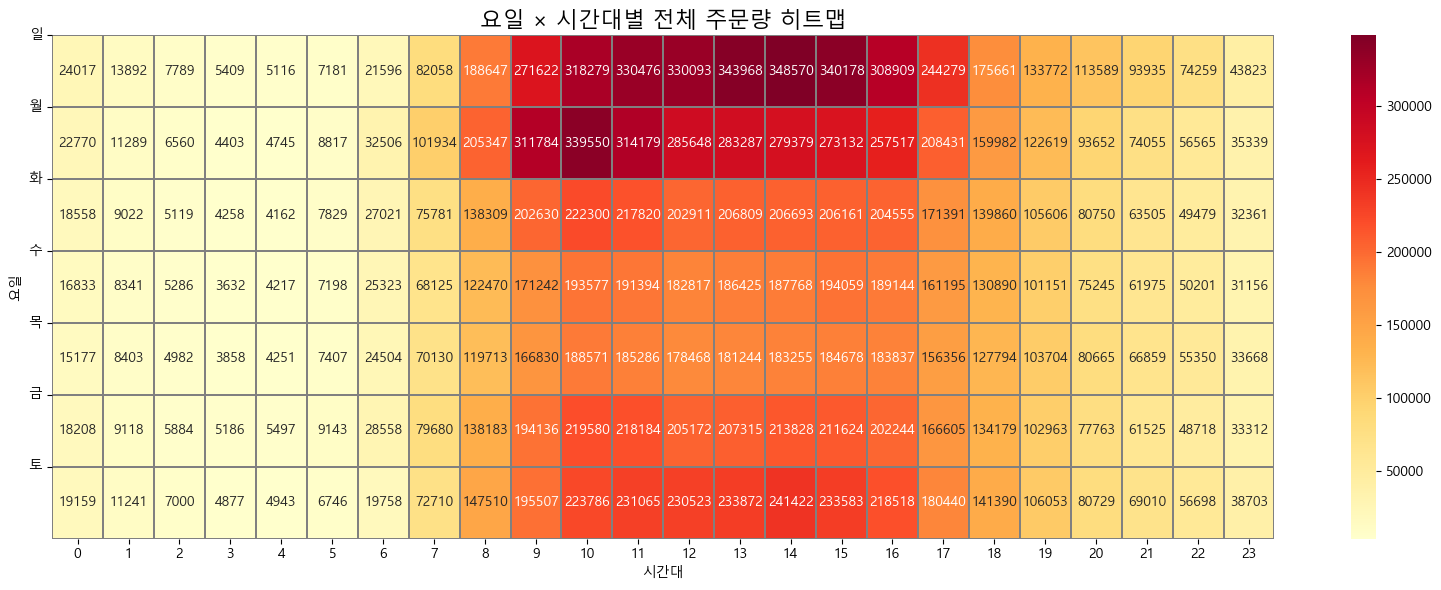

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. ÏöîÏùº √ó ÏãúÍ∞ÑÎåÄÎ≥Ñ Ï£ºÎ¨∏Îüâ ÏßëÍ≥Ñ
df_heatmap = df_total.groupby(['order_dow', 'order_hour_of_day']) \
                     .size().reset_index(name='order_count')

# 2. ÌîºÎ≤ó ÌÖåÏù¥Î∏î ÎßåÎì§Í∏∞
pivot_heatmap = df_heatmap.pivot(index='order_dow', columns='order_hour_of_day', values='order_count').fillna(0)

# 3. ÌûàÌä∏Îßµ ÏãúÍ∞ÅÌôî
plt.figure(figsize=(16, 6))
sns.heatmap(pivot_heatmap, cmap='YlOrRd', linewidths=0.3, linecolor='gray', annot=True, fmt='g')

plt.title('ÏöîÏùº √ó ÏãúÍ∞ÑÎåÄÎ≥Ñ Ï†ÑÏ≤¥ Ï£ºÎ¨∏Îüâ ÌûàÌä∏Îßµ', fontsize=16)
plt.xlabel('ÏãúÍ∞ÑÎåÄ')
plt.ylabel('ÏöîÏùº')
plt.xticks(rotation=0)
plt.yticks(ticks=range(7), labels=['Ïùº', 'Ïõî', 'Ìôî', 'Ïàò', 'Î™©', 'Í∏à', 'ÌÜ†'], rotation=0)
plt.tight_layout()
plt.show()


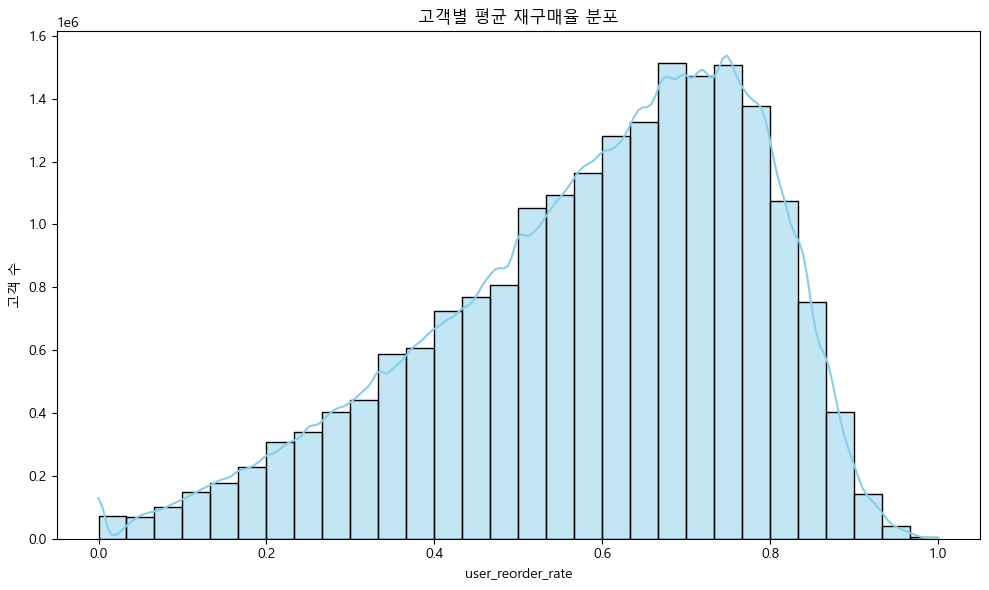

In [28]:
plt.figure(figsize=(10, 6))
sns.histplot(df_total['user_reorder_rate'], bins=30, kde=True, color='skyblue')
plt.title('Í≥†Í∞ùÎ≥Ñ ÌèâÍ∑† Ïû¨Íµ¨Îß§Ïú® Î∂ÑÌè¨')
plt.xlabel('user_reorder_rate')
plt.ylabel('Í≥†Í∞ù Ïàò')
plt.tight_layout()
plt.show()


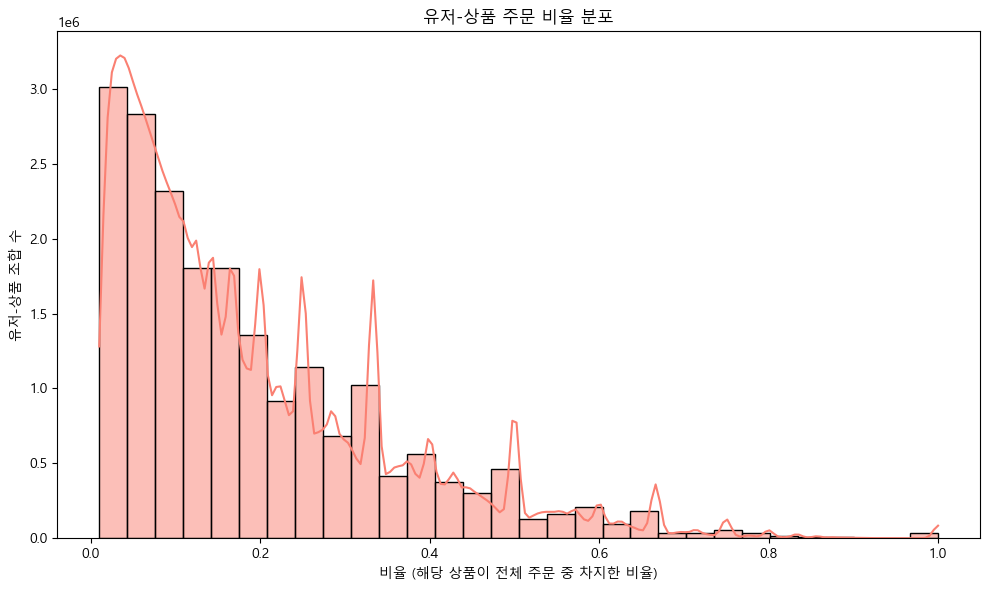

In [29]:
plt.figure(figsize=(10, 6))
sns.histplot(df_total['user_product_order_ratio'], bins=30, kde=True, color='salmon')
plt.title('Ïú†Ï†Ä-ÏÉÅÌíà Ï£ºÎ¨∏ ÎπÑÏú® Î∂ÑÌè¨')
plt.xlabel('ÎπÑÏú® (Ìï¥Îãπ ÏÉÅÌíàÏù¥ Ï†ÑÏ≤¥ Ï£ºÎ¨∏ Ï§ë Ï∞®ÏßÄÌïú ÎπÑÏú®)')
plt.ylabel('Ïú†Ï†Ä-ÏÉÅÌíà Ï°∞Ìï© Ïàò')
plt.tight_layout()
plt.show()


In [30]:
## Î®∏Ïã†Îü¨Îãù

In [31]:
df_encoded_clean = df_total.copy()

# Î¨∏ÏûêÏó¥ ‚Üí Ïà´ÏûêÌòïÏúºÎ°ú Ïù∏ÏΩîÎî©
from sklearn.preprocessing import LabelEncoder
categorical_cols = df_encoded_clean.select_dtypes(include='object').columns.tolist()
le = LabelEncoder()

for col in categorical_cols:
    try:
        df_encoded_clean[col] = le.fit_transform(df_encoded_clean[col].astype(str))
    except:
        print(f"Encoding failed for: {col}")

df_encoded_clean = df_encoded_clean.dropna()  # Í≤∞Ï∏°Ïπò Ï†úÍ±∞


In [32]:
from sklearn.model_selection import train_test_split

df_sampled = df_encoded_clean.sample(n=500_000, random_state=42)  # 50Îßå Í∞ú Ï†ïÎèÑÎßå ÏÉòÌîåÎßÅ

X = df_sampled.drop(columns=['reordered', 'order_id', 'user_id', 'product_id'])
y = df_sampled['reordered']

# Train/Test Î∂ÑÎ¶¨
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score

# 1. Î™®Îç∏ ÏÉùÏÑ± Î∞è ÌïôÏäµ
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42
)
rf_model.fit(X_train, y_train)

# 2. ÏòàÏ∏°
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# 3. ÏÑ±Îä• ÌèâÍ∞Ä Ï∂úÎ†•
print("üìä [RandomForest] Classification Report:")
print(classification_report(y_test, y_pred_rf))

# 4. Ï†ïÌôïÎèÑ & AUC Ï∂îÍ∞Ä Ï∂úÎ†•
acc = accuracy_score(y_test, y_pred_rf)
auc = roc_auc_score(y_test, y_proba_rf)

print(f"‚úÖ Accuracy: {acc:.4f}")
print(f"üéØ ROC AUC Score: {auc:.4f}")


üìä [RandomForest] Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     41003
           1       0.97      0.97      0.97     58997

    accuracy                           0.96    100000
   macro avg       0.96      0.96      0.96    100000
weighted avg       0.96      0.96      0.96    100000

‚úÖ Accuracy: 0.9597
üéØ ROC AUC Score: 0.9948


In [34]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [35]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score

# 1. Î™®Îç∏ ÏÉùÏÑ± Î∞è ÌïôÏäµ
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb_model.fit(X_train, y_train)

# 2. ÏòàÏ∏°
y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# 3. ÏÑ±Îä• ÌèâÍ∞Ä Ï∂úÎ†•
print("üìä [XGBoost] Classification Report:")
print(classification_report(y_test, y_pred_xgb))

# 4. Ï†ïÌôïÎèÑ & AUC
acc_xgb = accuracy_score(y_test, y_pred_xgb)
auc_xgb = roc_auc_score(y_test, y_proba_xgb)

print(f"‚úÖ Accuracy: {acc_xgb:.4f}")
print(f"üéØ ROC AUC Score: {auc_xgb:.4f}")


c:\Users\ihdmc\anaconda3\envs\myconda\lib\site-packages\xgboost\core.py:158: UserWarning: [14:04:20] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


üìä [XGBoost] Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95     41003
           1       0.97      0.97      0.97     58997

    accuracy                           0.96    100000
   macro avg       0.96      0.96      0.96    100000
weighted avg       0.96      0.96      0.96    100000

‚úÖ Accuracy: 0.9627
üéØ ROC AUC Score: 0.9954


In [36]:
import lightgbm as lgb
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score

# 1. Î™®Îç∏ ÏÉùÏÑ± Î∞è ÌïôÏäµ
lgb_model = lgb.LGBMClassifier(
    n_estimators=100,
    max_depth=-1,
    min_data_in_leaf=10,
    learning_rate=0.1,
    random_state=42,
    verbose=-1
)
lgb_model.fit(X_train, y_train)

# 2. ÏòàÏ∏°
y_pred_lgb = lgb_model.predict(X_test)
y_proba_lgb = lgb_model.predict_proba(X_test)[:, 1]

# 3. ÏÑ±Îä• ÌèâÍ∞Ä Ï∂úÎ†•
print("üìä [LightGBM] Classification Report:")
print(classification_report(y_test, y_pred_lgb))

# 4. Ï†ïÌôïÎèÑ & AUC
acc_lgb = accuracy_score(y_test, y_pred_lgb)
auc_lgb = roc_auc_score(y_test, y_proba_lgb)

print(f"‚úÖ Accuracy: {acc_lgb:.4f}")
print(f"üéØ ROC AUC Score: {auc_lgb:.4f}")


üìä [LightGBM] Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96     41003
           1       0.98      0.97      0.97     58997

    accuracy                           0.97    100000
   macro avg       0.97      0.97      0.97    100000
weighted avg       0.97      0.97      0.97    100000

‚úÖ Accuracy: 0.9680
üéØ ROC AUC Score: 0.9962


In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score

# 1. Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ (ÏÉòÌîåÎßÅÎêú Îç∞Ïù¥ÌÑ∞ ÏÇ¨Ïö© Í∞ÄÏ†ï)
X = df_sampled.drop(columns=['reordered', 'order_id', 'user_id', 'product_id'])
y = df_sampled['reordered']

# 2. ÌïôÏäµ Îç∞Ïù¥ÌÑ∞ Î∂ÑÎ¶¨
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 3. Î™®Îç∏ ÌïôÏäµ
log_model = LogisticRegression(
    max_iter=1000,  # Î∞òÎ≥µ Ïàò Ï∂©Î∂ÑÌûà ÎäòÎ¶¨Í∏∞
    solver='lbfgs',  # Í∏∞Î≥∏ solver
    random_state=42
)
log_model.fit(X_train, y_train)

# 4. ÏòàÏ∏°
y_pred_log = log_model.predict(X_test)
y_proba_log = log_model.predict_proba(X_test)[:, 1]

# 5. ÌèâÍ∞Ä
print("üìä [Logistic Regression] Classification Report:")
print(classification_report(y_test, y_pred_log))

acc_log = accuracy_score(y_test, y_pred_log)
auc_log = roc_auc_score(y_test, y_proba_log)

print(f"‚úÖ Accuracy: {acc_log:.4f}")
print(f"üéØ ROC AUC Score: {auc_log:.4f}")


üìä [Logistic Regression] Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.94      0.87     41003
           1       0.95      0.84      0.90     58997

    accuracy                           0.88    100000
   macro avg       0.88      0.89      0.88    100000
weighted avg       0.89      0.88      0.89    100000

‚úÖ Accuracy: 0.8842
üéØ ROC AUC Score: 0.9553


C:\Users\ihdmc\AppData\Local\Temp\ipykernel_14588\1246641334.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=lgb_feat, y=lgb_feat.index, palette='magma')


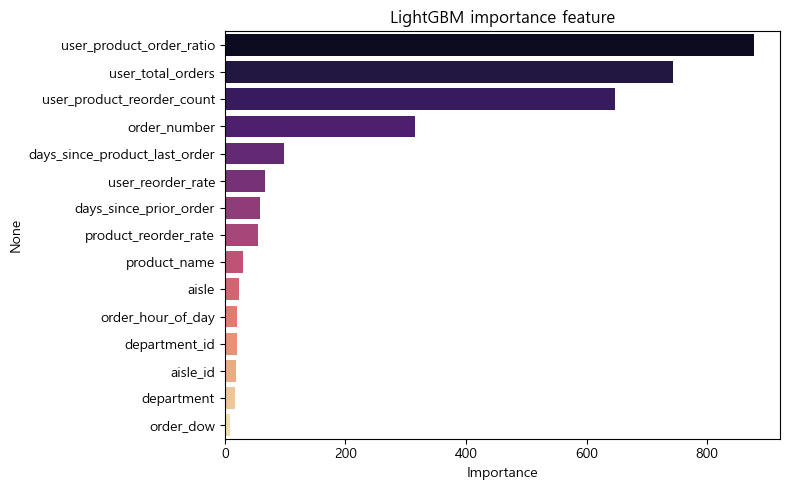

In [38]:

# 6. Feature Importance (LightGBM Í∏∞Ï§Ä ÏãúÍ∞ÅÌôî)
lgb_feat = pd.Series(lgb_model.feature_importances_, index=X.columns).sort_values(ascending=False)
lgb_feat = lgb_feat[lgb_feat.index != 'Unnamed__0']
plt.figure(figsize=(8, 5))
sns.barplot(x=lgb_feat, y=lgb_feat.index, palette='magma')
plt.title('LightGBM importance feature')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

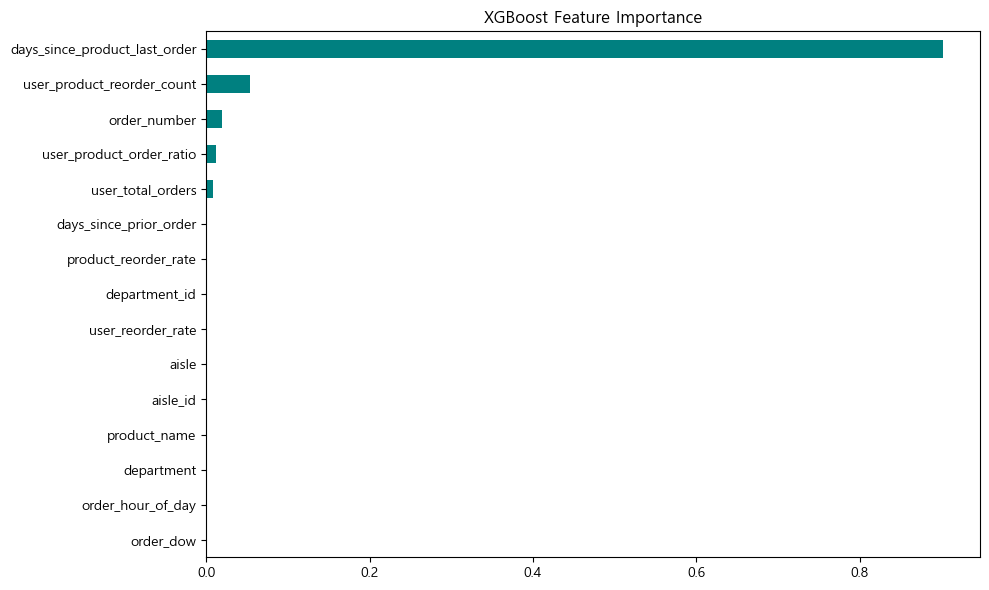

In [39]:
xgb_feat = pd.Series(xgb_model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
xgb_feat.head(20).plot(kind='barh', color='teal')
plt.title('XGBoost Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import pandas as pd

# 1. Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ: ÌîºÏ≤òÏôÄ ÌÉÄÍ≤ü ÏßÄÏ†ï
# df_encoded_cleanÏóêÎäî 'reordered', 'order_id', 'user_id', 'product_id' Ïª¨ÎüºÏù¥ Ìè¨Ìï®ÎêòÏñ¥ ÏûàÎã§Í≥† Í∞ÄÏ†ï
X = df_encoded_clean.drop(columns=['reordered', 'order_id', 'user_id', 'product_id'])
y = df_encoded_clean['reordered']

# 2. Îç∞Ïù¥ÌÑ∞ Î∂ÑÌï†: 70:20:10 (train:validation:test) (Stratified Î∞©Ïãù)
# Î®ºÏ†Ä 90%ÏôÄ 10%Î°ú Î∂ÑÎ¶¨Ìïú ÌõÑ, 90% Ï§ëÏóêÏÑú 2/9 (ÏïΩ 22.2%)Î•º validationÏúºÎ°ú Î∂ÑÎ¶¨ÌïòÎ©¥,
# ÏµúÏ¢ÖÏ†ÅÏúºÎ°ú train:validation:test = 70:20:10 Ïù¥ ÎêúÎã§.
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=2/9, stratify=y_temp, random_state=42)

# 3. Í≤∞Í≥º Ï†ÄÏû•Ïö© ÎîïÏÖîÎÑàÎ¶¨ ÏÉùÏÑ±
results = {}

# 4. ÌèâÍ∞Ä Ìï®Ïàò Ï†ïÏùò: Î™®Îç∏ ÌïôÏäµ ÌõÑ, ValidationÍ≥º Test Îç∞Ïù¥ÌÑ∞Ïóê ÎåÄÌï¥ classification_report Í∏∞Ï§Ä ÌèâÍ∞Ä ÏßÄÌëú Ï†ÄÏû•
def evaluate_model(name, model):
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)
    
    val_report = classification_report(y_val, y_val_pred, output_dict=True)
    test_report = classification_report(y_test, y_test_pred, output_dict=True)
    
    results[name] = {
        'val_precision': round(val_report['weighted avg']['precision'], 2),
        'val_recall': round(val_report['weighted avg']['recall'], 2),
        'val_f1': round(val_report['weighted avg']['f1-score'], 2),
        'val_accuracy': round(val_report['accuracy'], 2),
        'test_precision': round(test_report['weighted avg']['precision'], 2),
        'test_recall': round(test_report['weighted avg']['recall'], 2),
        'test_f1': round(test_report['weighted avg']['f1-score'], 2),
        'test_accuracy': round(test_report['accuracy'], 2)
    }

# 5. Í∞Å Î™®Îç∏Î≥Ñ ÌïôÏäµ Î∞è ÌèâÍ∞Ä

# Logistic Regression (ÌÅ¥ÎûòÏä§ Î∂àÍ∑†Ìòï Ï≤òÎ¶¨Î•º ÏúÑÌï¥ class_weight='balanced' ÏÇ¨Ïö©)
evaluate_model('Logistic', LogisticRegression(max_iter=100, class_weight='balanced', random_state=42))

# Random Forest (ÌÅ¥ÎûòÏä§ Î∂àÍ∑†Ìòï Ï≤òÎ¶¨Î•º ÏúÑÌï¥ class_weight='balanced' ÏÇ¨Ïö©)
evaluate_model('Random Forest', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))

# XGBoost: ÌïôÏäµ Ïãú ÌÅ¥ÎûòÏä§ Î∂àÍ∑†Ìòï Î≥¥Ï†ïÏùÑ ÏúÑÌï¥ scale_pos_weight ÏÑ§Ï†ï (ÏñëÏÑ±/ÏùåÏÑ± ÎπÑÏú®)
pos_ratio = sum(y_train == 0) / sum(y_train == 1)
evaluate_model('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, scale_pos_weight=pos_ratio))

# LightGBM: is_unbalance=True ÏòµÏÖòÏúºÎ°ú Î∂àÍ∑†Ìòï Î≥¥Ï†ï
evaluate_model('LightGBM', LGBMClassifier(random_state=42, is_unbalance=True))

# 6. Í≤∞Í≥º ÌÖåÏù¥Î∏îÎ°ú Ï†ïÎ¶¨ÌïòÏó¨ Ï∂úÎ†•
df_results = pd.DataFrame(results).T
print("\nüìã Î™®Îç∏ ÏÑ±Îä• ÎπÑÍµê (Validation & Test):\n")
print(df_results)


c:\Users\ihdmc\anaconda3\envs\myconda\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
